# 쿠팡이츠

## 감성분석

In [16]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import re
import nltk
import konlpy
import seaborn as sns
import platform
from matplotlib import font_manager, rc
from konlpy.tag import Okt
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn import svm

In [17]:
app_data = pd.read_csv('clean_coupang-eats_v2.0.csv')

In [18]:
app_data.head()

,review,date,rating,y
0,전문성있는 배달라이더분들이 걸리면 빨리옵니다 근데 운없어서 자동차나 도보 자전거 걸...,7/31/2021 13:52,1,0
1,맛있게 잘 먹었어요 파스타와 고르곤졸라 익숙한 맛있는 맛이구요 감바스는 처음 주문해...,7/31/2021 8:18,5,1
2,라이더 실시간 위치 알려주는 기능 이 기능 소비자 입장에서 무조건 좋을 것 같지만 ...,7/30/2021 21:43,2,0
3,너무 배달비가 비싼 집은 거르고 싶어서 필터를 종종 사용하는데요배달비가 결국 금액 ...,7/30/2021 6:39,3,0
4,무료배달이라고 써져있는데 막상 시켜보면 원이 붙어있고 ㅜㅡㅜ 코로나때문에 집에서 혼...,7/30/2021 4:52,5,1


In [19]:
app_data['review'].nunique(), app_data['rating'].nunique()

(2751, 5)

In [20]:
okt = Okt()

# 말뭉치 생성
corpus = "".join(app_data['review'].tolist())
corpus

'전문성있는 배달라이더분들이 걸리면 빨리옵니다 근데 운없어서 자동차나 도보 자전거 걸리면 그냥 배달대행 하는 사람들보다 더 늦게옴ㅋㅋ 무슨 뽑기도 아니고ㅋㅋㅋ네비 보고 오느라 길 계속 틀리고 결국 내가 찾으러 나간것만 번 ㅋㅋㅋㅋ심지어 우리집 복잡한 골목에 있는것도 아니고 대로변에 있는데 그리고 도보로 오시는 분들은 물건 손에 달랑달랑 들고옵니다 교육좀 시키세요 그리고 꿀팁 하나 드리자면 배달시키는 상점 자기 집에서 가까우면 걍 배민으로 시켜드세요 키로 이상이면 쿠팡 이용하시구 근데 쿠팡이여도 늦게올땐 늦게오네요ㅋㅋ맛있게 잘 먹었어요 파스타와 고르곤졸라 익숙한 맛있는 맛이구요 감바스는 처음 주문해봤는데 약간 매콤하니 딱 좋았어요라이더 실시간 위치 알려주는 기능 이 기능 소비자 입장에서 무조건 좋을 것 같지만 요즘 이거 보다가 화병 납니다 배달 인원은 부족하고 이 사람 저 사람 전부 배달 시작하다보니 배민에서는 겪은 적 없는 일들을 여기서 다 겪습니다 주소 떡하니 적혀있는데 몇동 몇호냐고 연락오는 라이더들 배달원 주차 걱정을 내가 하게되는 자동차 배달 등등 안그래도 배고파서 예민해져있을 때 더 신경쓸 일만 늘어나고 실제로 배달에 걸린 시간이 그리 많이 걸린 것도 아닌데 실시간 라이더 위치를 볼 수 있으니 은근히 계속 신경쓰게 되고 정말 상대가 완벽한 배달을 제공할 수 있는게 아니라면 만족도를 떨어뜨리는 원인이 되는 것 같습니다 처음엔 저만 너무 예민한가 했는데 여기 댓글 보니 배달 문제 때문에 얘기가 많네요 라이더 인원이 부족해서 가려 받을 때가 아니라면 교통수단이나 라이더 실시간 위치 기능을 없애시는 게 나을 것 같고 그 기능을 없앨 수 없다면 라이더 교육에 더 신경써서 해주세요너무 배달비가 비싼 집은 거르고 싶어서 필터를 종종 사용하는데요배달비가 결국 금액 기준으로 또 나뉘게 되니까 필터를 써도 가게 클릭해서 들어간 다음에 상세페이지에서 배달비자세히를 봐야 주문금액별 정확한 배달비를 알 수 있으니 너무 불편해요적어도 가장 싼 배달비에 대한 가능 주문금액이 가

In [21]:
# 불용어 사전
stopwords = pd.read_csv('stopword.txt')

In [22]:
def text_cleaning(text) :
    hangul = re.compile('[^ ㄱ-ㅣ 가-힣]')  # 정규 표현식 처리
    result = hangul.sub('', text)
    okt = Okt()  # 형태소 추출
    nouns = okt.nouns(result)
    nouns = [x for x in nouns if len(x) > 1]  # 한글자 키워드 제거
    nouns = [x for x in nouns if x not in stopwords]  # 불용어 제거
    return nouns

## 임베딩

#### BoW 벡터 생성

In [23]:
vect = CountVectorizer(tokenizer = lambda x: text_cleaning(x)) # tokenizer로 위에서 정의한 text_cleansing 함수 사용
bow_vect = vect.fit_transform(app_data['review'].tolist())
word_list = vect.get_feature_names()
count_list = bow_vect.toarray().sum(axis = 0)

#### TF-IDF 적용

In [24]:
tfidf_vectorizer = TfidfTransformer()
tf_idf_vect = tfidf_vectorizer.fit_transform(bow_vect)
invert_index_vectorizer = {v:k for k, v in vect.vocabulary_.items()}
print(str(invert_index_vectorizer)[:100]+'...')

{2827: '전문성', 1301: '배달', 910: '라이더', 2719: '자동차', 785: '도보', 2734: '자전거', 383: '그냥', 742: '대행', 159...


### 감성분석

#### 별점 분포 확인(시각화 자표 포함)

In [16]:
app_data['rating'].value_counts()

5    1308
1     979
4     177
3     171
2     116
Name: rating, dtype: int64

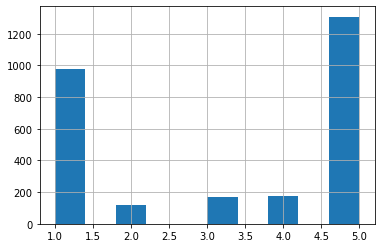

In [15]:
app_data['rating'].hist()
plt.savefig('쿠팡 star-rating.png' , dpi=300)

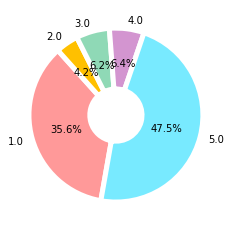

In [17]:
ratio = [979, 116, 171, 177, 1308]
labels = ['1.0', '2.0', '3.0', '4.0', '5.0']
colors = ['#ff9999', '#ffc000', '#8fd9b6', '#d395d0', '#78EAFF']
wedgeprops={'width': 0.7, 'edgecolor': 'w', 'linewidth': 5}

plt.pie(ratio, labels=labels, autopct='%.1f%%', startangle=260, counterclock=False, colors=colors, wedgeprops=wedgeprops)
plt.savefig('쿠팡 pie-chart.png', dpi = 300)
plt.show()

#### 별점 라벨링(1,2,3점은 부정 4,5점은 긍정)

In [25]:
def rating_to_label(rating) :
    if rating > 3 :
        return 1
    else :
        return 0
    
app_data['y'] = app_data['rating'].apply(lambda x : rating_to_label(x))

In [26]:
app_data['y'].value_counts()

1    1485
0    1266
Name: y, dtype: int64

In [27]:
# 각각 4501개씩 추출 : 클래스 불균형 해소
positive_random_idx = app_data[app_data['y']==1].sample(1266, random_state=12).index.tolist()
negative_random_idx = app_data[app_data['y']==0].sample(1266, random_state=12).index.tolist()

In [28]:
random_idx = positive_random_idx + negative_random_idx
x_data = tf_idf_vect[random_idx]
y_data = app_data['y'][random_idx]
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data,
                                                    test_size = 0.25, 
                                                    random_state = 102)
print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)

(1899, 3783) (633, 3783) (1899,) (633,)


#### 모델 성능 비교(by accuracy_score)

# Logistic Regression

In [29]:
# fit in training set
lr = LogisticRegression(random_state=0)
lr.fit(x_train, y_train)

# predict in test set
y_pred = lr.predict(x_test)

# classification result for test set
print('accuracy: %.2f' % accuracy_score(y_test, y_pred))

accuracy: 0.77


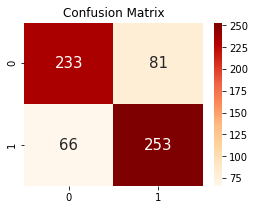

In [20]:
# confusion matrix
matrix = confusion_matrix(y_true = y_test, y_pred = y_pred)
plt.figure(figsize = (4, 3))
sns.heatmap(matrix, annot=True, annot_kws={'size':15}, cmap='OrRd', fmt='.10g')
plt.title('Confusion Matrix')
plt.savefig('쿠팡 confusion matrix(lr).png', dpi=300)
plt.show()

In [21]:
lr.coef_

array([[-0.80270503, -0.012007  ,  0.11127904, ..., -0.05639738,
        -0.22355501, -0.134808  ]])

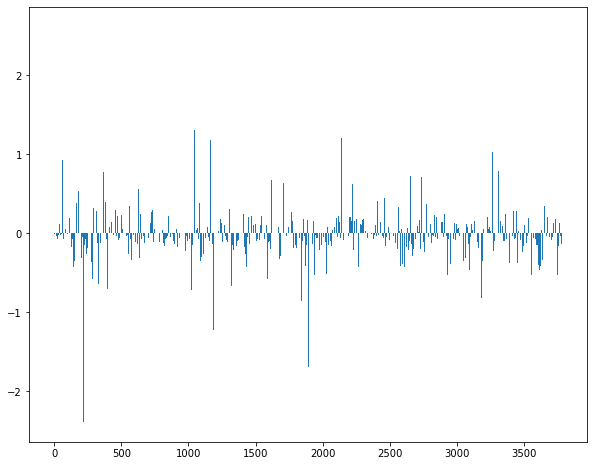

In [22]:
# print logistic regression's coef

plt.figure(figsize=(10, 8))
plt.bar(range(len(lr.coef_[0])), lr.coef_[0])
plt.savefig('쿠팡 lr_coef.png')

In [30]:
coef_pos_index = sorted(((value, index) for index, value in enumerate(lr.coef_[0])), reverse = True)
coef_neg_index = sorted(((value, index) for index, value in enumerate(lr.coef_[0])), reverse = False)
coef_pos_index

[(2.6173611921654434, 3238),
 (1.9725017340592583, 1317),
 (1.6263883967006392, 1301),
 (1.5697281333310467, 2879),
 (1.4318401066329642, 2996),
 (1.3572796278584092, 1973),
 (1.3198086683841281, 1031),
 (1.3111708501375254, 1045),
 (1.278418696103481, 1796),
 (1.2403059098287956, 3369),
 (1.2123270871760812, 2141),
 (1.1805417025408904, 1164),
 (1.1795784423537212, 2103),
 (1.171922115967194, 1953),
 (1.1410595817679743, 1595),
 (1.1315901399869326, 2706),
 (1.0606711727221325, 3688),
 (1.0289402456628973, 3267),
 (0.9943232285041236, 2039),
 (0.984065214056534, 3354),
 (0.9299869902172585, 61),
 (0.9053324137416624, 1318),
 (0.8691422793731608, 708),
 (0.8415824743501403, 3649),
 (0.8291961342910487, 3675),
 (0.8212102195156897, 3247),
 (0.8167874984407275, 3367),
 (0.8157729427885766, 2511),
 (0.8029144737763764, 1815),
 (0.7902074619448194, 3312),
 (0.7810066597044066, 2587),
 (0.7796648223368479, 366),
 (0.7740937180261784, 757),
 (0.7710692295322433, 1700),
 (0.7615510752984651, 

In [31]:
pos_keyword = []
pos_value = []
# 긍정 키워드 상위 20개
for coef in coef_pos_index[:20] :
    print(invert_index_vectorizer[coef[1]], coef[0])
    pos_keyword.append(invert_index_vectorizer[coef[1]])
    pos_value.append(coef[0])

pos_keyword.sort()

최고 2.6173611921654434
배송 1.9725017340592583
배달 1.6263883967006392
정말 1.5697281333310467
주시 1.4318401066329642
실시간 1.3572796278584092
만족 1.3198086683841281
맛집 1.3111708501375254
속도 1.278418696103481
쿠팡잇츠 1.2403059098287956
어디 1.2123270871760812
무엇 1.1805417025408904
애용 1.1795784423537212
신세계 1.171922115967194
사랑 1.1410595817679743
잇츠 1.1315901399869326
현황 1.0606711727221325
추천 1.0289402456628973
아주 0.9943232285041236
코로나 0.984065214056534


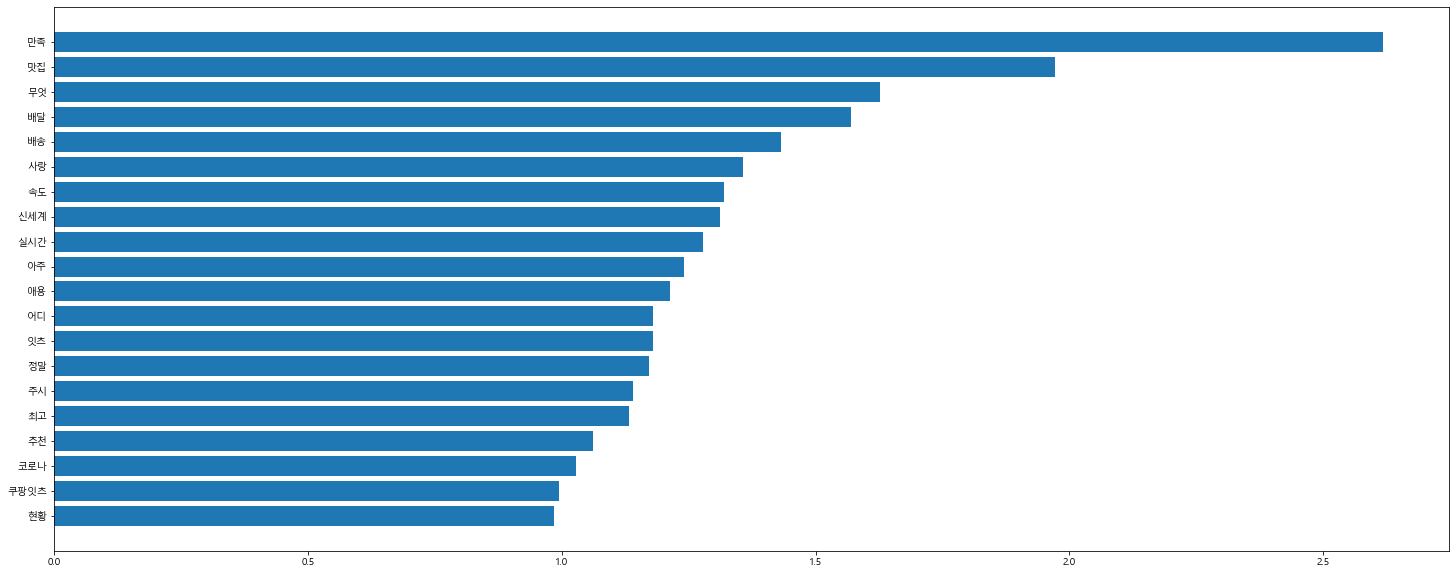

In [26]:
if platform.system() == 'Windows': 
    plt.rc('font', family='Malgun Gothic')


x = np.arange(21)
keyword = pos_keyword
value = pos_value
plt.figure(figsize=(25, 10))
plt.barh(keyword, value)
plt.gca().invert_yaxis()
plt.savefig('쿠팡 긍정 20.png')
plt.show()

In [32]:
neg_keyword = []
neg_value = []

# 부정 키워드 상위 20개
for coef in coef_neg_index[:20] :
    print(invert_index_vectorizer[coef[1]], coef[0])
    neg_keyword.append(invert_index_vectorizer[coef[1]])
    neg_value.append(coef[0])

고객 -2.3890060006594465
그냥 -2.258788979917096
전화 -1.992086571553786
센터 -1.8339833849167995
사람 -1.7254450577458007
이유 -1.725422127151542
시간 -1.6932321991574868
로그인 -1.6837953203247011
삭제 -1.6817529161572062
제대로 -1.6797405921324524
다시 -1.6700299472317177
무슨 -1.60817024784551
취소 -1.506463570365839
때문 -1.502499714120459
잘못 -1.494183033623953
갑자기 -1.4916815115084983
오류 -1.4481143741187186
탈퇴 -1.4029781221128466
자동차 -1.4026600237041045
쓰레기 -1.3939184325528662


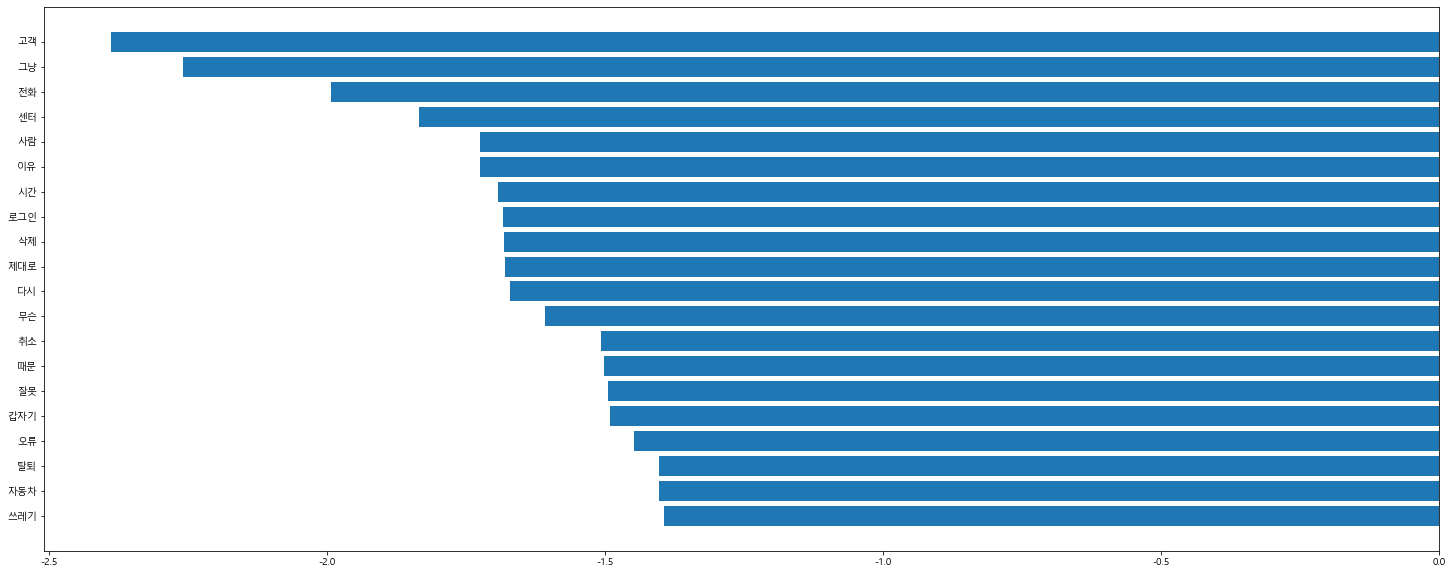

In [28]:
if platform.system() == 'Windows': 
    plt.rc('font', family='Malgun Gothic')

x = np.arange(21)
keyword = neg_keyword
value = neg_value
plt.figure(figsize=(25, 10))
plt.barh(keyword, value)
plt.rcParams['axes.unicode_minus'] = False
plt.gca().invert_yaxis()
plt.savefig('쿠팡 부정 20.png')
plt.show()

### Naive_Bayes
- x값은 이용자 리뷰의 평가 내용
- y값은 이용자의 긍/부정 감성

In [33]:
nb_clf = BernoulliNB()
nb_clf.fit(x_train, y_train)

y_pred_nb = nb_clf.predict(x_test)
print('accuracy: %.2f' % accuracy_score(y_test, y_pred_nb))

accuracy: 0.70


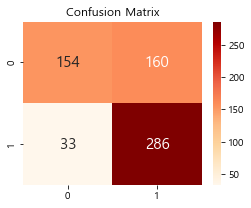

In [30]:
# confusion matrix
confu = confusion_matrix(y_true = y_test, y_pred = y_pred_nb)

plt.figure(figsize=(4, 3))
sns.heatmap(confu, annot=True, annot_kws={'size':15}, cmap='OrRd', fmt='.10g')
plt.title('Confusion Matrix')
plt.savefig('쿠팡 confusion-matrix(nb).png', dpi=300)
plt.show()

# SVM
- linear

In [33]:
clf_lin = svm.LinearSVC()
clf_lin.fit(x_train, y_train)

y_pred_lin = clf_lin.predict(x_test)

print(confusion_matrix(y_test, y_pred_lin))
print('accuracy: %.2f' % accuracy_score(y_test, y_pred_lin))

[[221  93]
 [ 67 252]]
accuracy: 0.75


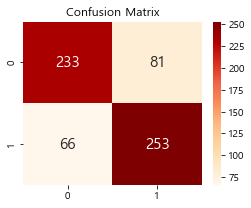

In [34]:
# confusion matrix
matrix = confusion_matrix(y_true = y_test, y_pred = y_pred)
plt.figure(figsize = (4, 3))
sns.heatmap(matrix, annot=True, annot_kws={'size':15}, cmap='OrRd', fmt='.10g')
plt.title('Confusion Matrix')
plt.savefig('쿠팡 confusion-matrix(SVM_lin).png', dpi=300)
plt.show()

In [35]:
clf_lin.coef_

array([[-0.25896608, -0.0403464 ,  0.30876376, ..., -0.06715244,
        -0.4106352 , -0.31362372]])

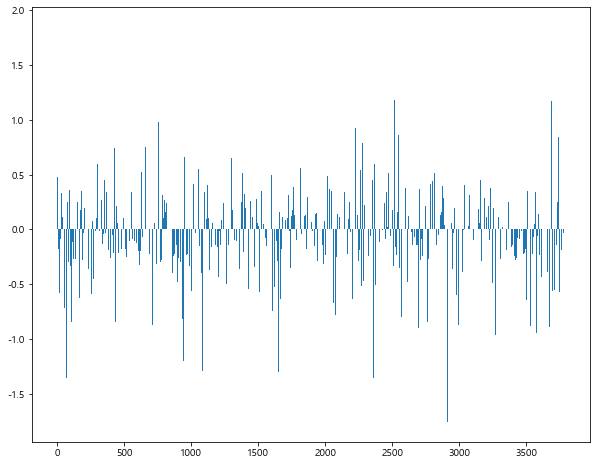

In [36]:
# print logistic regression's coef

plt.figure(figsize=(10, 8))
plt.bar(range(len(clf_lin.coef_[0])), clf_lin.coef_[0])

In [37]:
coef_pos_index_svm = sorted(((value, index) for index, value in enumerate(clf_lin.coef_[0])), reverse = True)
coef_neg_index_svm = sorted(((value, index) for index, value in enumerate(clf_lin.coef_[0])), reverse = False)
coef_pos_index_svm

[(1.8508681738726644, 2996),
 (1.6650645093734946, 3238),
 (1.3314197523290279, 2697),
 (1.2192550075782675, 3675),
 (1.210460659175743, 3580),
 (1.182387866782548, 2517),
 (1.1721474138340433, 3688),
 (1.1476318925720157, 1796),
 (1.123539424203859, 3649),
 (1.1209332306001933, 2706),
 (1.1057195781606655, 1815),
 (1.1044088790825823, 1031),
 (1.0814953522438036, 2103),
 (1.0650667166238932, 515),
 (1.0048922583760787, 60),
 (0.9912226741098453, 3312),
 (0.9817996421226902, 757),
 (0.9646973349295251, 3369),
 (0.9462303776226958, 566),
 (0.9446331444768145, 1274),
 (0.9402654547162032, 3099),
 (0.9388370551708524, 1178),
 (0.9375519259197864, 708),
 (0.93340206005634, 1002),
 (0.9284734314332919, 2226),
 (0.925985846692858, 3354),
 (0.9191168997852567, 2566),
 (0.9023139422542931, 288),
 (0.8775395417250146, 1083),
 (0.8680740665082408, 381),
 (0.864590935801002, 408),
 (0.8624245678004481, 3475),
 (0.8616465659957905, 3258),
 (0.8607092147983917, 2547),
 (0.8464953654353193, 2082),
 

In [38]:
# 긍정 키워드 TOP 20
for coef in coef_pos_index_svm[:20]:
    print(invert_index_vectorizer[coef[1]], coef[0])

주시 1.8508681738726644
최고 1.6650645093734946
입력 1.3314197523290279
혁명 1.2192550075782675
하니 1.210460659175743
응답 1.182387866782548
현황 1.1721474138340433
속도 1.1476318925720157
해주시 1.123539424203859
잇츠 1.1209332306001933
수가 1.1057195781606655
만족 1.1044088790825823
애용 1.0814953522438036
나중 1.0650667166238932
감동 1.0048922583760787
친절 0.9912226741098453
더욱 0.9817996421226902
쿠팡잇츠 0.9646973349295251
네이버 0.9462303776226958
발견 0.9446331444768145


In [39]:
# 부정 키워드 TOP 20
for coef in coef_neg_index_svm[:20]:
    print(invert_index_vectorizer[coef[1]], coef[0])

제대로 -1.7573623551368924
이유 -1.60086459368598
때문 -1.4961004528042186
그냥 -1.463724997841355
전화 -1.4579156767785537
고객 -1.4513186217384282
잘못 -1.4438364689258292
자전거 -1.434965514997354
가요 -1.4059957504783247
갑자기 -1.355667430696136
요가 -1.3546320780805456
점점 -1.3407124980561267
만원 -1.3239994312037697
아이폰 -1.3174186922122473
상담사 -1.297354472716559
무슨 -1.2889043611386315
멋대로 -1.2874168152525882
굳이 -1.2871372580275262
우리 -1.2724791820457677
집앞 -1.2554646778907408


- polynomial kernel

In [40]:
clf_poly = svm.SVC(kernel = 'poly', degree = 3)
clf_poly.fit(x_train, y_train)

y_pred_poly = clf_poly.predict(x_test)

print(confusion_matrix(y_test, y_pred_poly))
print('accuracy: %.2f' % accuracy_score(y_test, y_pred_poly))

[[265  49]
 [110 209]]
accuracy: 0.75


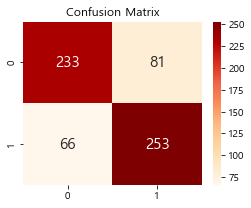

In [41]:
# confusion matrix
matrix = confusion_matrix(y_true = y_test, y_pred = y_pred)
plt.figure(figsize = (4, 3))
sns.heatmap(matrix, annot=True, annot_kws={'size':15}, cmap='OrRd', fmt='.10g')
plt.title('Confusion Matrix')
plt.savefig('쿠팡 confusion-matrix(SVM_poly).png', dpi=300)
plt.show()

- radial basis function

In [42]:
clf_rbf = svm.SVC(kernel = 'rbf', gamma = 0.5)
clf_rbf.fit(x_train, y_train)

y_pred_rbf = clf_rbf.predict(x_test)

print(confusion_matrix(y_test, y_pred_rbf))
print('accuracy: %.2f' % accuracy_score(y_test, y_pred_rbf))

[[240  74]
 [ 65 254]]
accuracy: 0.78


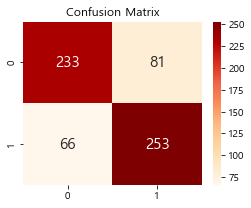

In [43]:
# confusion matrix
matrix = confusion_matrix(y_true = y_test, y_pred = y_pred)
plt.figure(figsize = (4, 3))
sns.heatmap(matrix, annot=True, annot_kws={'size':15}, cmap='OrRd', fmt='.10g')
plt.title('Confusion Matrix')
plt.savefig('쿠팡 confusion-matrix(SVM_rbf).png', dpi=300)
plt.show()

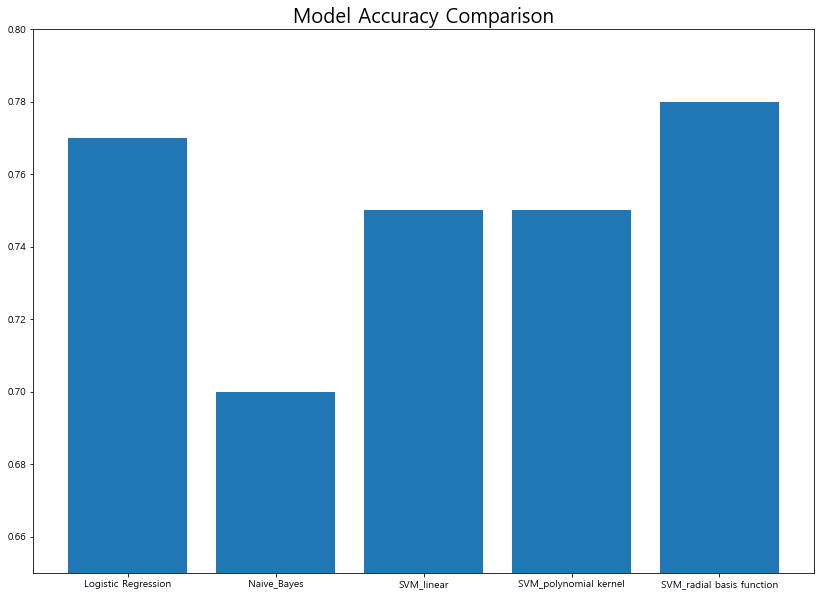

In [34]:
model = ['Logistic Regression', 'Naive_Bayes', 'SVM_linear', 'SVM_polynomial kernel', 'SVM_radial basis function']
accuracy = [0.77, 0.70, 0.75, 0.75, 0.78]


x = np.arange(6)
model_kind = model
accuracy_score = accuracy
plt.figure(figsize=(14, 10))
plt.bar(model_kind, accuracy_score)
plt.title('Model Accuracy Comparison', size = 20)
plt.ylim(0.65, 0.8)
plt.savefig('auc 그래프.png')
plt.show()

## 연관어 분석

### 전처리 및 토큰화

In [35]:
# 불용어 불러옴
with open('stopword.txt', 'r', encoding='utf-8-sig') as f:
    data = f.read()
stopword = data.splitlines()

In [36]:
from konlpy.tag import Okt

results = []
lines = list(np.array(app_data['review'].tolist()))

for line in lines:
    # 형태소 분석하기
    # 단어의 기본형 사용
    malist = okt.pos(line, stem=True) # 토큰화
    for i in range(len(malist)):
        malist[i] = list(malist[i])
    malist = [x for x in malist if len(x[0]) > 1]  # 한글자 키워드 제거
    malist = [x for x in malist if x not in stopword]
    r = []
    for word in malist:
        # 어미/조사/구두점 등은 대상에서 제외
        if word[1] == "Noun": 
            r.append(word[0])
            
    results.append(r)
    
# 명사만 갖고 오고 싶다?
# if word[1] == "Noun"

### Word2Vec 모델

In [37]:
from collections import Counter
from gensim.models.word2vec import Word2Vec

# Word2Vec 모델 생성
model = Word2Vec(results, vector_size = 200, window = 10, min_count = 2, sg = 1)

## 긍부정 TOP20 키워드로 연관어 분석

#### 긍정 키워드 TOP 20

In [56]:
with open('pos_coupang.txt', 'r', encoding='CP949') as f:
    data = f.read()
pos_keyword = data.splitlines()

In [57]:
print(pos_keyword)

['최고', '배송', '실시간', '속도', '배달', '아주', '애용', '추천', '만족', '맛집', '무엇', '사랑', '잇츠', '요즘', '자주', '쿠팡잇츠', '추가', '주시', '어디', '다른']


In [54]:
for pos_keyword in pos_keyword :
    print(model.wv.most_similar(pos_keyword))

[('배민', 0.9914138317108154), ('제일', 0.9897128343582153), ('이제', 0.9896001815795898), ('비도', 0.9885786175727844), ('맛집', 0.9882495403289795), ('요기', 0.9869714379310608), ('여기', 0.9833517074584961), ('애용', 0.9828343391418457), ('로켓', 0.982509195804596), ('수수료', 0.9818870425224304)]
[('분만', 0.9940258264541626), ('준비', 0.991020917892456), ('정도', 0.9896765351295471), ('실제', 0.9880949258804321), ('기분', 0.986976683139801), ('치킨', 0.9836811423301697), ('점점', 0.9785959124565125), ('거의', 0.9780023694038391), ('음식점', 0.9763442873954773), ('언제', 0.9753698110580444)]
[('현황', 0.9906585812568665), ('비도', 0.971808135509491), ('이상', 0.9705718159675598), ('여기', 0.9680745005607605), ('어디', 0.9666559100151062), ('기본', 0.9665128588676453), ('최고', 0.9659574031829834), ('얼마', 0.9655044078826904), ('음식점', 0.9638155698776245), ('거리', 0.9627842903137207)]
[('기요', 0.9980961680412292), ('장점', 0.9962136745452881), ('잇츠', 0.9960823059082031), ('애용', 0.9960291981697083), ('가장', 0.9959830045700073), ('무엇', 0.99597948

#### 부정 키워드 TOP 20

In [58]:
with open('neg_coupang.txt', 'r', encoding='CP949') as f:
    data = f.read()
neg_keyword = data.splitlines()

In [59]:
print(neg_keyword)

['고객', '센터', '이유', '사람', '그냥', '광고', '전화', '계속', '취소', '기사', '로그인', '제대로', '잘못', '무슨', '삭제', '쓰레기', '시간', '보고', '갑자기', '수수료']


In [60]:
for neg_keyword in neg_keyword :
    print(model.wv.most_similar(neg_keyword))

[('센터', 0.9944630265235901), ('연결', 0.9853889346122742), ('전화', 0.9840890765190125), ('연락', 0.984032154083252), ('통화', 0.9761252403259277), ('환불', 0.9750234484672546), ('상담', 0.9742565751075745), ('상황', 0.9731404781341553), ('취소', 0.9660020470619202), ('요청', 0.9572187662124634)]
[('고객', 0.9944629669189453), ('연락', 0.9878190159797668), ('전화', 0.9867274165153503), ('통화', 0.9803872108459473), ('연결', 0.979876697063446), ('환불', 0.9745039939880371), ('상황', 0.9706071019172668), ('상담', 0.9649145603179932), ('취소', 0.955289363861084), ('요청', 0.9464192986488342)]
[('일단', 0.9961679577827454), ('이츠', 0.9953321218490601), ('보통', 0.994759738445282), ('대부분', 0.9936436414718628), ('떡볶이', 0.9931978583335876), ('표시', 0.9928104281425476), ('배송비', 0.9922928810119629), ('한번', 0.9921731948852539), ('입점', 0.9921701550483704), ('면서', 0.9920656085014343)]
[('기존', 0.9879260063171387), ('또한', 0.9875648021697998), ('그게', 0.9870526790618896), ('번갈아', 0.9865020513534546), ('민사', 0.9864689707756042), ('시국', 0.9864173

In [61]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import matplotlib as mpl
import matplotlib.pyplot as plt
from gensim.models import KeyedVectors
from matplotlib import font_manager, rc
font_path = "C:/Windows/Fonts/malgun.ttf"
font = font_manager.FontProperties(fname=font_path).get_name()
rc('font', family=font)

# 그래프에서 마이너스 폰트 깨지는 문제에 대한 대처
mpl.rcParams['axes.unicode_minus'] = False

In [62]:
def show_tsne():
    tsne = TSNE(n_components=2) 
    X = tsne.fit_transform(X_show)
    df = pd.DataFrame(X, index=vocab_show, columns=['x', 'y']) 
    fig = plt.figure() 
    fig.set_size_inches(30, 20) 
    ax = fig.add_subplot(1, 1, 1) 
    ax.scatter(df['x'], df['y'])

    for word, pos in df.iterrows(): 
        ax.annotate(word, pos, fontsize=10)

    plt.xlabel("t-SNE 특성 0") 
    plt.ylabel("t-SNE 특성 1") 
    #plt.show()

In [63]:
def show_pca():
    # PCA 모델을 생성합니다 
    pca = PCA(n_components=2) 
    pca.fit(X_show) 
    # 처음 두 개의 주성분으로 숫자 데이터를 변환합니다 
    x_pca = pca.transform(X_show)

    plt.figure(figsize=(45, 35)) 
    plt.xlim(x_pca[:, 0].min(), x_pca[:, 0].max()) 
    plt.ylim(x_pca[:, 1].min(), x_pca[:, 1].max()) 
    colors = ['#476A2A', '#7851B8']
    for i in range(len(X_show)): 
        plt.text(x_pca[i, 0], x_pca[i, 1], str(vocab_show[i]), 
                 fontdict={'weight': 'bold', 'size': 9}) 
    plt.xlabel("첫 번째 주성분") 
    plt.ylabel("두 번째 주성분") 
    #plt.show()

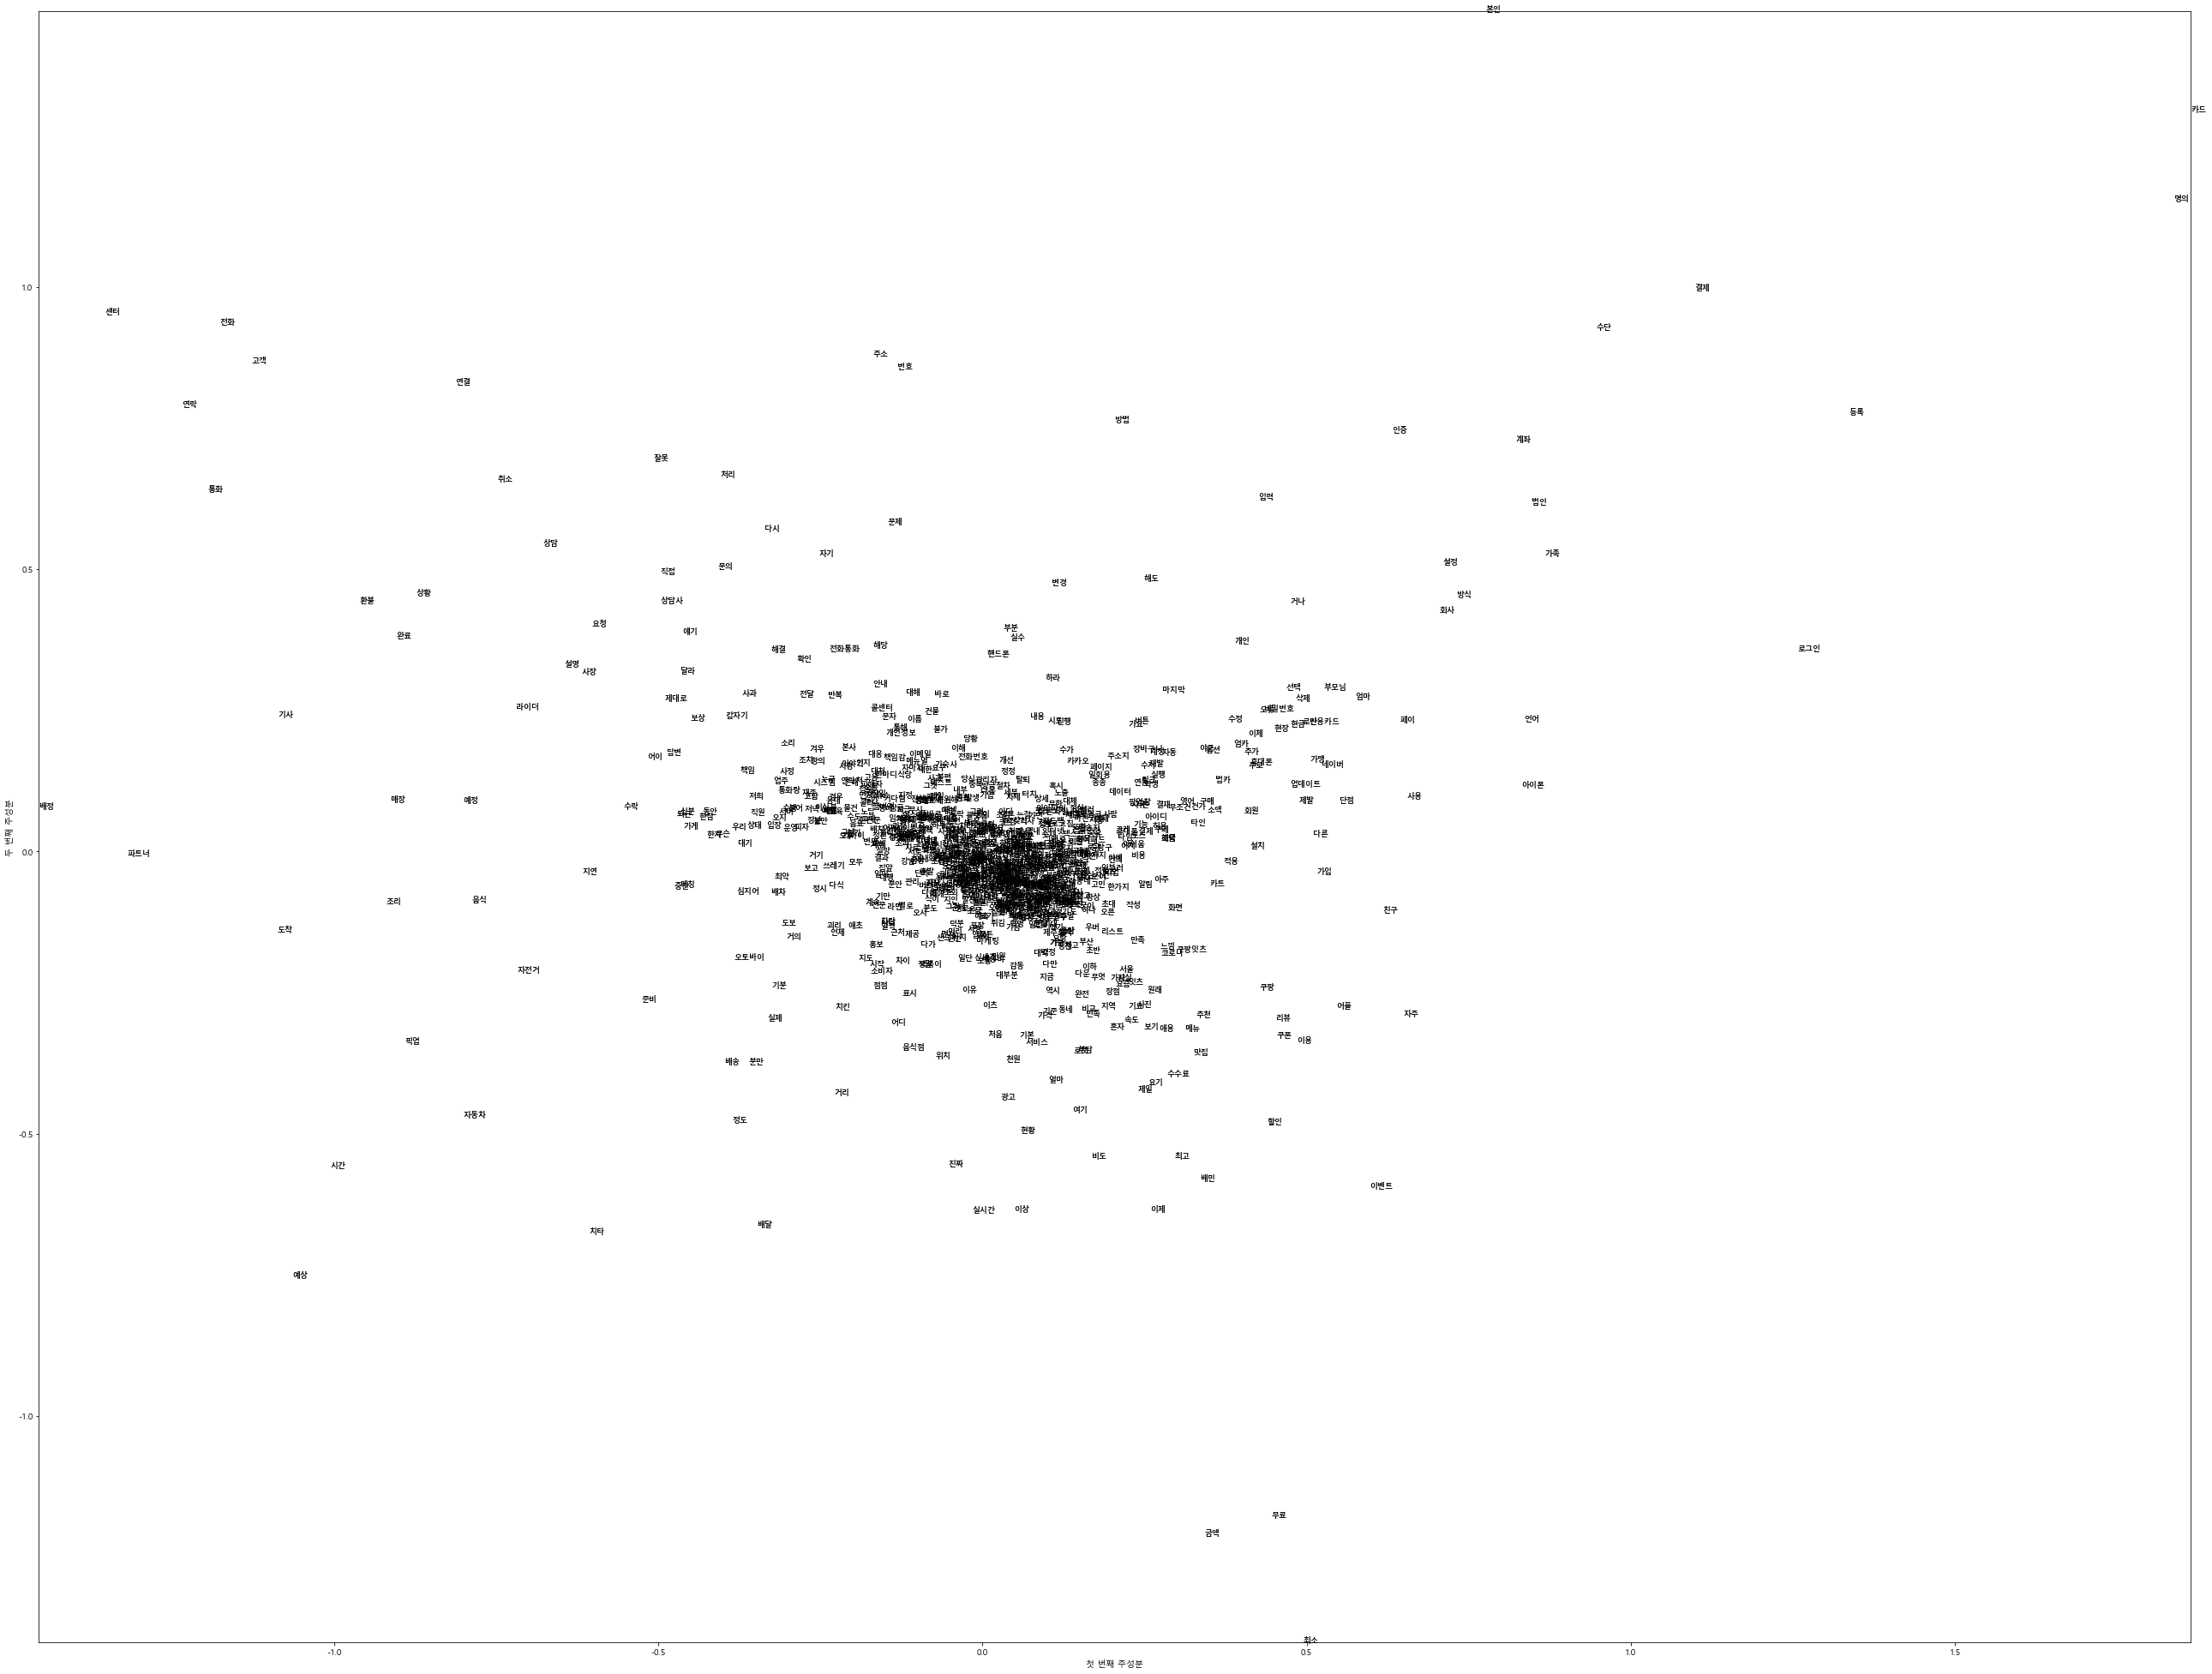

In [64]:
vocab = list(model.wv.key_to_index)
X = model.wv[vocab]

# sz개의 단어에 대해서만 시각화
sz = 1000
X_show = X[:sz,:] 
vocab_show = vocab[:sz] 

show_pca()
plt.savefig('쿠팡 pca.png')

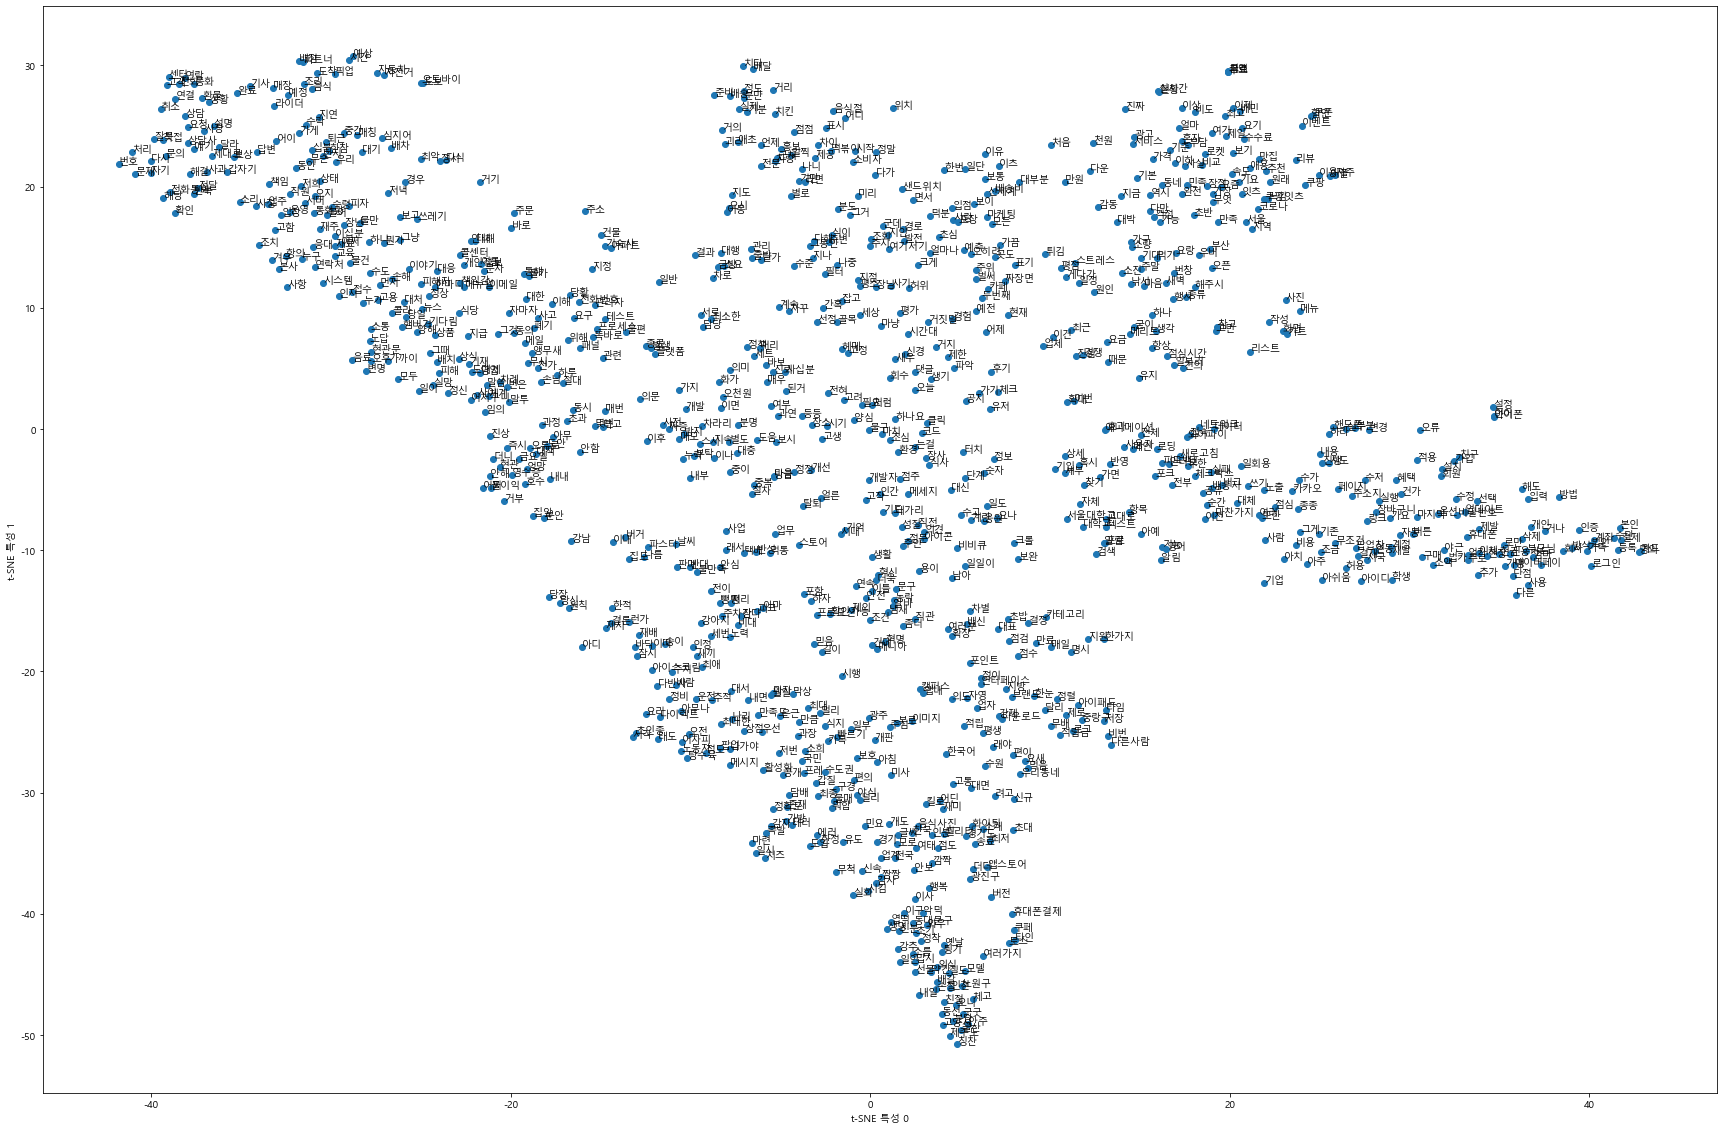

In [65]:
show_tsne() 
plt.savefig('쿠팡 tsne.png')

## 토픽모델링
- 4,5점을 제외한 리뷰데이터만 추출하여 부정적인 의견을 시각화하려고 함

### 전처리 및 토큰화

#### 4,5점을 제외한 리뷰데이터만 추출

In [38]:
# 4점을 제외한 리뷰데이터만 추출
df_45x = []
for i in range(len(app_data)):
    if app_data['rating'][i] < 4:
        df_45x.append(app_data['review'][i])
    else:
        continue
        
df_45x = pd.DataFrame(df_45x)
df_45x.rename(columns={0:'REVIEW'}, inplace=True)

#### apply_regular_expression 함수 정의

In [39]:
def apply_regular_expression(text):
    hangul = re.compile('[^ ㄱ-ㅣ 가-힣]')  # 한글 추출 규칙: 띄어 쓰기(1 개)를 포함한 한글
    result = hangul.sub('', text)  # 위에 설정한 "hangul"규칙을 "text"에 적용(.sub)시킴
    return result

#### 정규 표현식 적용

In [40]:
for i in range(len(df_45x)):
    df_45x['REVIEW'][i] = apply_regular_expression(df_45x['REVIEW'][i])

#### 토큰화

In [41]:
okt = Okt()
docs = []
lines = df_45x['REVIEW'].tolist()

for line in lines:
    # 단어의 기본형 사용
    malist = okt.nouns(line) # 토큰화
    malist = [x for x in malist if len(x) > 1]  # 한글자 키워드 제거
    malist = [x for x in malist if x not in stopword]
    docs.append(malist)

#### get_nouns 함수 정의

In [42]:
def get_nouns(text):
    nouns=okt.nouns(text)
    nouns=[word for word in nouns if len(word)>1]
    nouns = [word for word in nouns if word not in stopword]
    return nouns

### 임베딩

In [43]:
cv = CountVectorizer(tokenizer=get_nouns)
tdm = cv.fit_transform(df_45x['REVIEW'])
count=tdm.sum(axis=0)
count

matrix([[119,  12,   1, ...,   1,   1,   1]], dtype=int64)

In [44]:
word_count=pd.DataFrame({'단어':cv.get_feature_names(),
                        '빈도':count.flat})
word_count.sort_values(by="빈도",ascending=False)

,단어,빈도
947,배달,1316
2443,쿠팡,538
2177,주문,425
1820,음식,295
159,고객,242
...,...,...
1168,사내,1
1163,사경,1
1161,사거리,1
1160,삥삥,1


### 시각화 자료(빈도 분석, 워드클라우드)

#### 빈도 분석

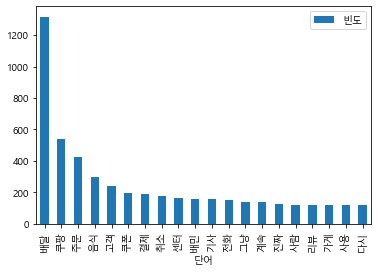

In [45]:
font_path = "C:/Windows/Fonts/malgun.ttf"
font = font_manager.FontProperties(fname=font_path).get_name()
rc('font', family=font)

word_count_index = word_count.copy()
word_count_index.index = word_count_index["단어"]
word_count_index.sort_values(by="빈도", ascending=False)[:20].plot.bar()
plt.savefig("쿠팡이츠_빈도분석.png")

#### 워드클라우드

In [88]:
# 추출한 명사 리스트를 활용해 명사만으로 이루어진 문서를 생성합니다.
docs_noun = docs.copy()

for i in range(len(docs_noun)):
    docs_noun[i] = ' '.join(docs_noun[i])
    
noun_doc = ' '.join(docs_noun)
noun_doc = noun_doc.strip()
noun_doc

'전문성 배달 라이더 자동차 도보 자전거 그냥 배달 대행 사람 뽑기 보고 계속 골목 대로 도보 오시 물건 교육 꿀팁 배달 상점 자기 배민 이면 쿠팡 이용 쿠팡 라이더 실시간 위치 기능 기능 소비자 입장 무조건 화병 배달 인원 사람 사람 전부 배달 시작 배민 주소 연락 라이더 배달 주차 걱정 자동차 배달 신경 일만 실제 배달 실시간 라이더 위치 은근 계속 신경 정말 상대 배달 제공 만족도 원인 처음 댓글 배달 문제 때문 얘기 라이더 인원 교통 수단 라이더 실시간 위치 기능 기능 라이더 교육 신경 배달 거르 필터 종종 사용 배달 금액 기준 필터 가게 클릭 상세 페이지 배달 주문 금액 배달 가장 배달 대한 가능 금액 가게 화면 일부러 디쟌 장난 아이스크림 위치 배달 집앞 아이스크림 배달 관계자 전화 전화 진짜 주문 취소 위치 서비스 진짜  집배 달도 자동자 자전거 배달 강남 거주 강북 자동차 타고 장난 서비스 응대 배민 님들 예전 자주 배민 정도 순간 이번 이용 삭제 배신 치타 배달 주문 치타 배달 이름 배민 차별 치타 배달 가게 배달 예상 쿠팡 이츠 주문 주문 마자 예상 주문 단계 안내 문구 결제 완료 매장 수락 예상 쿠팡 이츠 이유 처음 배달 매장 매장 근처 빙빙 취소 사람 최애 최악 자동차 라이더 거부 강남 복판 자동차 배달 픽업 음식 라이더 장난 음식 음식점 라이더 불어 문제점 전화 접수 개선 그것 애기 고객 센터 전달자 역활 설명 상담 수구 라이더 배차 취소 가게 조리 이의신청 정산 손실 보존 업주 확인 세상 거기 누락 된거 한마디 의도 운영 관리 측면 한참 수정 항상 쿠팡 사용 골목 찾기 배달 메세지 항상 음식 도착 문의 전혀 리뷰 작성 잘못 용이 문제 네이버 길찾기 사용 도착 항상 식이 개선 주문 요청 사항 제대로 기입 확인 해당 내용 확인 개선 쿠팡 배정 배달 무료 배달 만원 배달 만원 무료 배달 무료 배달 배달 그냥 규제 소비자 배민앱 처음 배달 배달 점점 별로 중간 중간 갑자기 배달 현황 곳도 정말 기분 분명 배달 기사 전화 소비자 배달 기사 보이

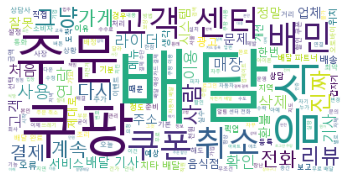

In [90]:
from wordcloud import WordCloud
font_path = "C:/Windows/Fonts/malgun.ttf"
font = font_manager.FontProperties(fname=font_path).get_name()
rc('font', family=font)

wc = WordCloud(font_path=font_path, background_color='white')
wc.generate(noun_doc)

plt.figure()
plt.imshow(wc)
plt.axis('off')
plt.savefig("쿠팡이츠_워드클라우드.png")

### 토픽모델링

In [92]:
from gensim import corpora, models
resultList=[]
keyword=5

texts=[]
for line in docs:
    tokens=[word for word in line if len(word)>1]
    texts.append(tokens)
    
dictionary = corpora.Dictionary(texts)
corpus=[dictionary.doc2bow(text) for text in texts]

ldamodel = models.ldamodel.LdaModel(corpus, id2word=dictionary, num_topics=5)

for num in range(5):
    resultList.append(ldamodel.show_topic(num, keyword))

In [93]:
ldamodel.print_topics(num_words=5)

[(0, '0.093*"배달" + 0.027*"쿠팡" + 0.020*"음식" + 0.019*"주문" + 0.016*"고객"'),
 (1, '0.072*"배달" + 0.019*"음식" + 0.015*"주문" + 0.013*"매장" + 0.013*"기사"'),
 (2, '0.043*"배달" + 0.042*"주문" + 0.036*"쿠팡" + 0.013*"고객" + 0.013*"사용"'),
 (3, '0.041*"쿠팡" + 0.031*"결제" + 0.027*"배달" + 0.022*"쿠폰" + 0.019*"주문"'),
 (4, '0.081*"배달" + 0.012*"쿠폰" + 0.011*"고객" + 0.011*"쿠팡" + 0.011*"리뷰"')]